In [1]:
import os

In [2]:
os.environ['OMP_NUM_THREADS'] = '1'

In [3]:
import gym, ray

from time import sleep
from pong import keep_ids

In [4]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [5]:
ray.init()

2019-02-20 20:11:03,131	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-20_20-11-03_8359/logs.
2019-02-20 20:11:03,237	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:23129 to respond...
2019-02-20 20:11:03,367	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:50533 to respond...
2019-02-20 20:11:03,374	INFO services.py:798 -- Starting Redis shard with 10.0 GB max memory.
2019-02-20 20:11:03,416	INFO services.py:1360 -- Starting the Plasma object store with 3.3281130489999997 GB memory using /dev/shm.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=f4856e7336e6595a446893a2ff47e6ea7896f3d24a79ad23



{'node_ip_address': None,
 'redis_address': '192.168.1.21:23129',
 'object_store_address': '/tmp/ray/session_2019-02-20_20-11-03_8359/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=f4856e7336e6595a446893a2ff47e6ea7896f3d24a79ad23',
 'raylet_socket_name': '/tmp/ray/session_2019-02-20_20-11-03_8359/sockets/raylet'}

In [6]:
device = torch.device('cuda')

In [7]:
env_name = 'Breakout-ramDeterministic-v4'

In [8]:
env = gym.make(env_name)

In [9]:
n = env.observation_space.shape[0]
a = env.action_space.n

In [10]:
rom_action = lambda a: a

Hyperparameters

In [11]:
n_steps = 10 ** 6
n_steps_test = 100
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 20
n_workers = 8
chi = 1e-2
lstm_memory_steps = 20

In [12]:
normalize = lambda x: (x / 127.5 - 1).astype(np.float32)

In [13]:
reward_normalize = lambda r: np.float32(r / 1)

In [14]:
entropy = lambda x: (-(F.log_softmax(x, dim=-1) * F.softmax(x, dim=-1)).sum(-1)).mean()

In [15]:
def param_cast(params, device):
    for k, v in params.items():
        if isinstance(v, torch.Tensor):
            params[k] = v.to(device)
            
    return params

## Create Model

In [16]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(n, 50, batch_first=True)
        self.fc = nn.Linear(50, a)
        self.device = torch.device('cpu')
        self.reset()
        
    def forward(self, x):
        x, self.h = self.rnn(x, self.h)
        return self.fc(x)
        
    def reset(self):
        self.h = None
        
    def to(self, *args, **kwargs):
        super().to(*args, **kwargs)
        self.device = self.fc.weight.data.device
        return self
    
    def detach(self):
        if self.h is not None:
            self.h = (self.h[0].detach(), self.h[1].detach())
        
    @torch.no_grad()
    def act(self, observation, probabilistic=True):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=self.device).view(1, 1, -1)
            
        if not probabilistic: 
            return self(observation).squeeze(0).max(dim=-1)[1].long()
        else:
            return torch.multinomial(F.softmax(self(observation).squeeze(0), dim=-1), 1).long()
        
actor = Actor().to(device)

In [17]:
class Critic(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Linear(n, 50), nn.SELU(), nn.Linear(50, 1))
        
critic = Critic().to(device)

In [18]:
optimizer_actor = optim.RMSprop(actor.parameters(), lr_actor)
optimizer_critic = optim.RMSprop(critic.parameters(), lr_critic)

In [19]:
@ray.remote
class Worker:
    def __init__(self):
        self.env = gym.make(env_name)
        self.actor = Actor()
        self.done = True
        self.steps = 0
        
    def run(self, parameters):
        self.actor.load_state_dict(parameters)
        
        states, actions, rewards = [], [], []
        to_reset = False
        
        if not self.done: states.append(self.state)
        while len(actions) < tau:
            if self.done:
                self.steps = 0
                to_reset = True
                self.actor.reset()
                self.state = normalize(env.reset())
                states.clear(); actions.clear(); rewards.clear()
                states.append(self.state)
            
            if not self.steps % lstm_memory_steps: self.actor.detach()
                
            action = self.actor.act(self.state).item()
            self.state, reward, self.done, _ = env.step(rom_action(action))
            self.state = normalize(self.state)
            states.append(self.state); actions.append(action)
            rewards.append(reward_normalize(reward))
            
        done = np.array(self.done, dtype=np.float32)
        to_reset = np.array(to_reset, dtype=np.float32)

        return np.stack(states), np.stack(actions), np.stack(rewards), done, to_reset

## Train

In [20]:
total_rewards = []
actor_losses = []
critic_losses = []
entropy_losses = []

In [21]:
def get_advantages(states, actions, rewards, dones):
    advantages = torch.zeros_like(rewards)
    
    optimizer_critic.zero_grad()
    
    # Remember to detach
    R = critic(states[:, -1]).squeeze(1).detach() * (1 - dones) # Returns
    
    for i in range(tau)[::-1]:
        R = rewards[:, i] + gamma * R
        advantages[:, i] = R - critic(states[:, i]).squeeze(1)
        
    return advantages

In [22]:
def train_actor_step(states, actions, advantages, to_reset):
    optimizer_actor.zero_grad()
    if actor.h is not None:
        actor.h[0][0] *= (1 - to_reset.unsqueeze(-1))
        actor.h[1][0] *= (1 - to_reset.unsqueeze(-1))
        
    action_scores = actor(states[:, :-1])
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_actor = torch.mean(torch.stack([adv * F.cross_entropy(s, a, reduction='none')
                                         for s, a, adv in zip(action_scores.transpose(0, 1),
                                                              actions.t(),
                                                              advantages.detach().t())]))
    loss_entropy = entropy(action_scores)
    loss = loss_actor - chi * loss_entropy
    loss.backward(retain_graph=True)
    optimizer_actor.step()
    
    return loss_actor.item(), loss_entropy.item()

In [23]:
def train_critic_step(advantages):
    # Remember to detach the advantages
    # We don't want the loss to affect the critic
    loss_critic = F.mse_loss(advantages, torch.zeros_like(advantages))
    loss_critic.backward()
    optimizer_critic.step()
    
    return loss_critic.item()

In [24]:
def test_one_episode(n_steps, probabilistic=True):
    l_actor = Actor().to(device)
    l_actor.load_state_dict(actor.state_dict())
    state = normalize(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(n_steps):
        action = l_actor.act(state, probabilistic).item()
        next_state, reward, done, _ = env.step(rom_action(action))
        
        total_rewards += reward
        state = normalize(next_state)
        if done: break
            
    return total_rewards

In [25]:
# """
actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor.pt'))
critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic.pt'))
optimizer_actor.load_state_dict(torch.load(DIR_NB / 'checkpoints' / 'actor-opt.pt'))
optimizer_critic.load_state_dict(torch.load( DIR_NB / 'checkpoints' / 'critic-opt.pt'))
# """

In [26]:
workers = [Worker.remote() for _ in range(n_workers)]

In [27]:
pbar = tqdm(range(n_steps // (tau * n_workers)))
for step in pbar:
    if not step % (lstm_memory_steps // tau): actor.detach()
        
    params = ray.put(param_cast(actor.state_dict(), 'cpu'))
    results = ray.get([worker.run.remote(params) for worker in workers])

    states, actions, rewards, dones, to_reset = [torch.tensor(np.stack(x), device=device)
                                                 for x in zip(*results)]

    advantages = get_advantages(states, actions, rewards, dones)

    loss_actor, loss_entropy = train_actor_step(states, actions, advantages, to_reset)
    loss_critic = train_critic_step(advantages)
    
    if not step % 100:
        actor_losses.append(loss_actor)
        entropy_losses.append(loss_entropy)
        critic_losses.append(loss_critic)
        total_rewards.append(test_one_episode(n_steps_test))
        pbar.set_description(f'{total_rewards[-1]:.2f}')

In [28]:
torch.save(actor.state_dict(), DIR_NB / 'checkpoints' / 'actor.pt')
torch.save(critic.state_dict(), DIR_NB / 'checkpoints' / 'critic.pt')
torch.save(optimizer_actor.state_dict(), DIR_NB / 'checkpoints' / 'actor-opt.pt')
torch.save(optimizer_critic.state_dict(), DIR_NB / 'checkpoints' / 'critic-opt.pt')

In [29]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

In [30]:
jtplot_style()

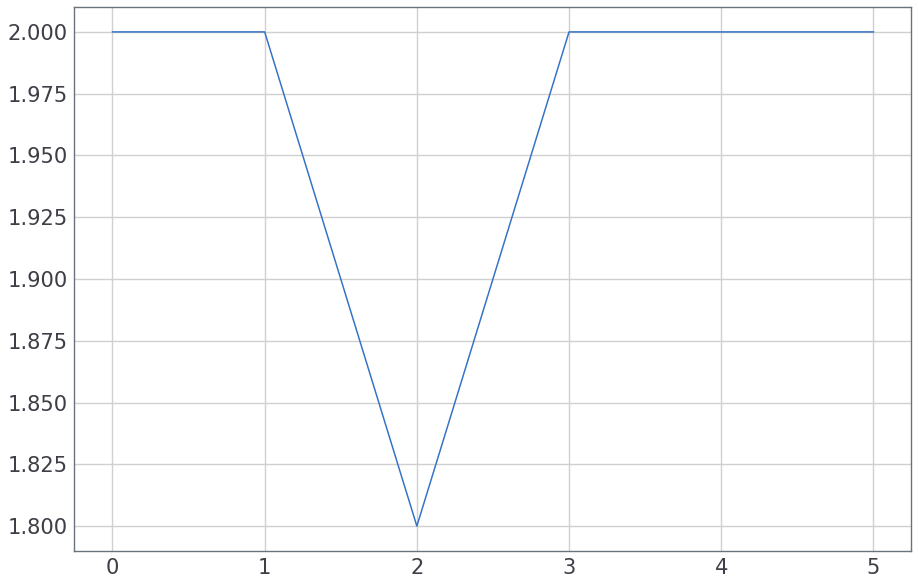

In [31]:
plot(groupmean(total_rewards, 10))

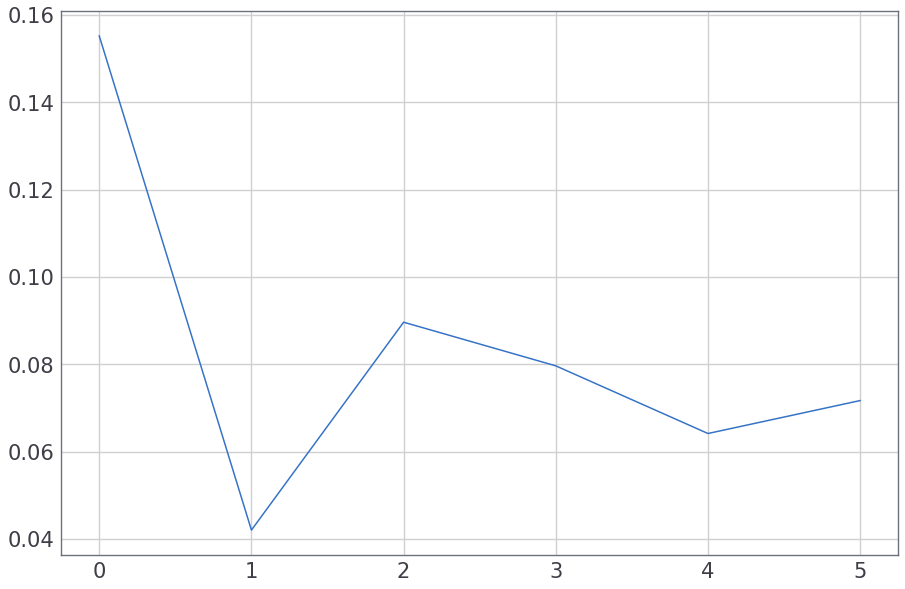

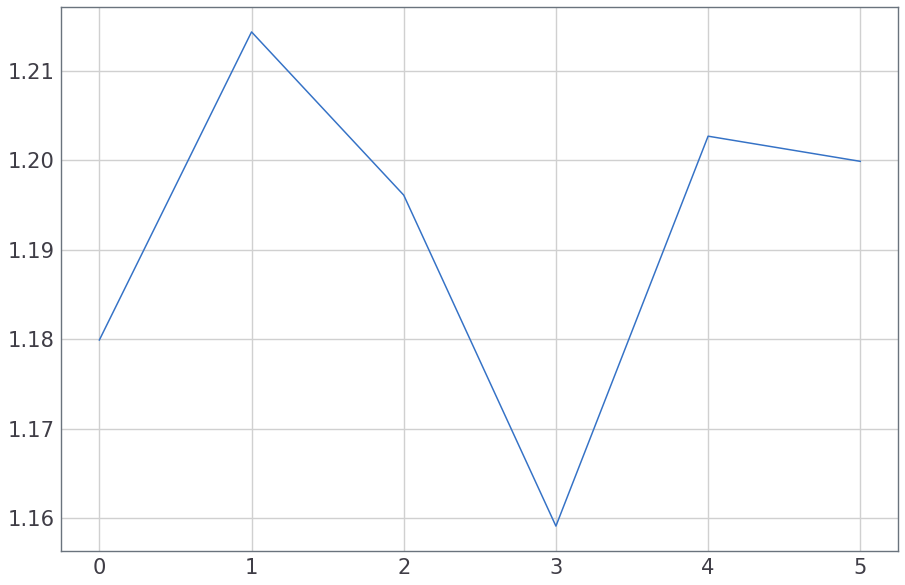

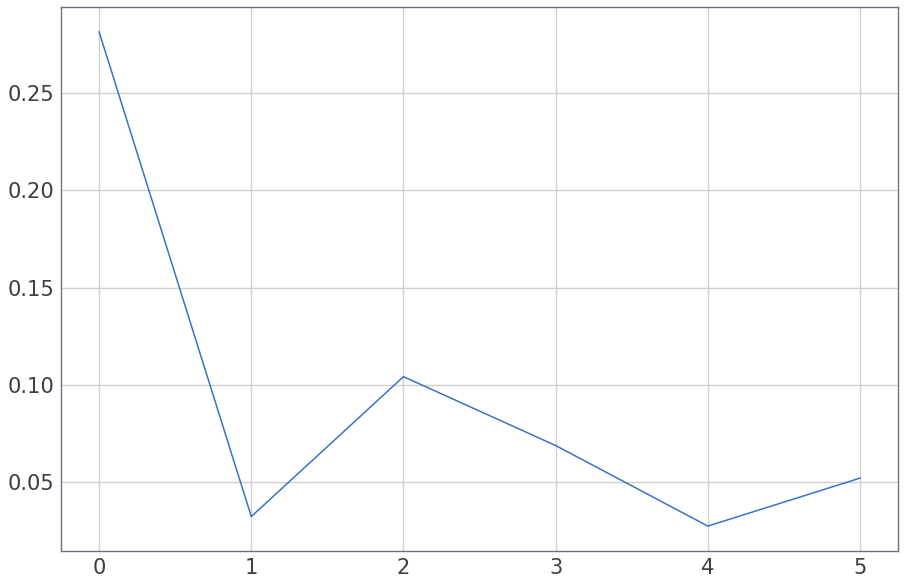

In [32]:
plot(groupmean(np.abs(actor_losses), 10)); plt.show()
plot(groupmean(np.abs(entropy_losses), 10)); plt.show()
plot(groupmean(critic_losses, 10)); plt.show()

In [33]:
test_one_episode(10000, probabilistic=False)

11.0

In [34]:
test_one_episode(10000, probabilistic=True)

7.0

In [35]:
for episode in range(1):
    actor.reset()
    state = normalize(env.reset())
    done = False
    r = 0

    for step in range(1000):
        env.render()
        action = actor.act(state, probabilistic=True).item()
        #with torch.no_grad():
            #a = actor(torch.tensor(state, device=device)).cpu().numpy()
            #print('Actor', a)
            #print('Critic', critic(torch.tensor(state, device=device)).squeeze().item())
        state, reward, done, _ = env.step(rom_action(action))
        state = normalize(state)
        r += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(r)
actor.reset()

11.0
